# Tutorial SEGMOOMOE via web services

This notebook describes the usage of segomoe using web services exposed by WhatsOpt.

## Prerequisite

### wop (WhatsOpt command line interface)

You have to install the `wop` command:

```bash
pip install -U wop 
```

You need to be logged in a WhatsOpt server either by using the <code>wop</code> command in a shell or the WhatsOpt API as follows:

In [1]:
from whatsopt.whatsopt_client import WhatsOpt
wop = WhatsOpt(url="https://ether.onera.fr/whatsopt")
ok = wop.login(echo=True)

Successfully logged in to remote WhatsOpt https://ether.onera.fr/whatsopt



To test if you are connected the following command should succeed

In [2]:
wop.check_versions()

WhatsOpt 1.25.4 requires wop >= 1.20.0
You are using wop 2.2.0


### SMT (Surrogate Modeling Toolbox)

SMT is not required per se, but is used in this notebook to get optimized LHS sampling method.

```bash
pip install smt
```

## Optimization with constraints

### Objective function

First we define the objective function we want to minimize

In [3]:
import numpy as np
from smt.applications.mixed_integer import FLOAT, INT

def fun(x):  # function with 3 objectives
    x = np.atleast_2d(x)
    f1 = x[:, 0] - x[:, 1] * x[:, 2]
    f2 = 4 * x[:, 0] ** 2 - 4 * x[:, 0] ** x[:, 2] + 1 + x[:, 1]
    f3 = x[:, 0] ** 2
    return np.hstack((np.atleast_2d(f1).T, np.atleast_2d(f2).T, np.atleast_2d(f3).T))


def g1(x):  # constraint to force x < 0.8
    x = np.atleast_2d(x)
    return np.atleast_2d(x[:, 0] - 0.8).T


def g2(x):  # constraint to force x > 0.2
    x = np.atleast_2d(x)
    return np.atleast_2d(0.2 - x[:, 0]).T


def f_grouped(x):
    resfun = fun(x)
    resg1 = g1(x)
    resg2 = g2(x)
    res = np.hstack((resfun, resg1, resg2))
    return res

### Optimization

First we create an optimization context to use the SEGMOOMOE optimizer with the design space <code>xlimits</code>.

In [4]:
from whatsopt.mooptimization import MOOptimization, FLOAT, INT

xtypes = [{"type": FLOAT, "limits": [0., 1.]},
          {"type": INT, "limits": [0, 3]},
          {"type": INT, "limits": [0, 3]}]

cstr_specs = 2*[{"type": '<', "bound": 0.0}]

options={"n_clusters": 0, "n_start": 10, "criterion": "PI", "pop_size": 30, "n_gen": 30, "verbose": True, "debug": True}

optim = MOOptimization(xtypes, n_obj=3, cstr_specs=cstr_specs, options=options)

You can get the optimization identifier

In [26]:
optim._id

184

This id is be used to identify the optimization and visualize the results when using the WhatsOpt web application. It can also be used at a lower level to handle the optimization when using WhatsOpt REST API.

We need to have an initial DOE (n_samples, nx) and the corresponding outputs y (n_samples, 1).

In [5]:
import numpy as np
# from smt.sampling_methods import LHS
# lhs = LHS(xlimits=np.array(xlimits), criterion='ese')
# xdoe = lhs(5)

xdoe = np.array(
    [        
     [0.36691555, 0.,        1.        ],
     [0.58432706, 1.,       1.        ],
     [0.09227899, 1.,         2.        ],
     [0.95274182, 1.,         2.        ],
     [0.72873502, 1.,         3.        ],
     [0.87115983, 2.,         1.        ],
     [0.24346361, 2.,         3.        ],
     [0.4221473 , 2.,         0.        ],
     [0.10886813, 2.,         1.        ],
     [0.65557784, 3.,         2.        ],
     [0.39532629, 2.,         0.        ]
    ]
)
ydoe = f_grouped(xdoe)
print("Initial DOE")
print("xdoe={}".format(xdoe))
print("ydoe={}".format(ydoe))

Initial DOE
xdoe=[[0.36691555 0.         1.        ]
 [0.58432706 1.         1.        ]
 [0.09227899 1.         2.        ]
 [0.95274182 1.         2.        ]
 [0.72873502 1.         3.        ]
 [0.87115983 2.         1.        ]
 [0.24346361 2.         3.        ]
 [0.4221473  2.         0.        ]
 [0.10886813 2.         1.        ]
 [0.65557784 3.         2.        ]
 [0.39532629 2.         0.        ]]
ydoe=[[ 0.36691555  0.07084588  0.13462702 -0.43308445 -0.16691555]
 [-0.41567294  1.02844421  0.34143811 -0.21567294 -0.38432706]
 [-1.90772101  2.          0.00851541 -0.70772101  0.10772101]
 [-1.04725818  2.          0.90771698  0.15274182 -0.75274182]
 [-2.27126498  2.5762262   0.53105473 -0.07126498 -0.52873502]
 [-1.12884017  2.55103848  0.75891945  0.07115983 -0.67115983]
 [-5.75653639  3.17937335  0.05927453 -0.55653639 -0.04346361]
 [ 0.4221473  -0.28716663  0.17820834 -0.3778527  -0.2221473 ]
 [-1.89113187  2.61193656  0.01185227 -0.69113187  0.09113187]
 [-5.34442216 

We initialize the optimizer with the inital DOE.

In [6]:
optim.tell_doe(xdoe, ydoe)

We trigger the optimization using the "ask and tell" interface.

In [7]:
# We loop using the iteration budget
n_iter = 2
with_best=False
for i in range(n_iter):
    with_best = with_best or (i == n_iter - 1)
    x_suggested, status, x_opt, y_opt = optim.ask(with_best)
    print("{} x suggested = {} with status: {}".format(i, x_suggested, MOOptimization.STATUSES[status]))

    # compute objective function at the suggested point
    new_y = f_grouped(x_suggested)
    print("new y = {}".format(new_y))

    optim.tell(x_suggested, new_y)
         
print("Found approx pareto y_opt = {} at x_opt = {}".format(y_opt, x_opt))

0 x suggested = [0.5586617983614292, 1.0, 1.0] with status: valid point
new y = [[-0.4413382   1.01376483  0.312103   -0.2413382  -0.3586618 ]]
1 x suggested = [0.800000911237212, 2.0, 0.0] with status: valid point
new y = [[ 8.00000911e-01  1.56000583e+00  6.40001458e-01  9.11237212e-07
  -6.00000911e-01]]
Found approx pareto y_opt = [[-4.82387751095713, 2.375406588176781, 1.0222750630753625], [-1.6876330688025811, 2.4556880406042154, 0.03828524129012545], [-7.50912035736423, 2.6029867638812165, 0.13300802040919665], [0.3752269683158649, 1.7232681305487025, 0.04994414834797084], [-7.469571871247251, 2.886708380330337, 0.057591618240452225], [0.35984441589360694, -0.4060856997640776, 0.13697629405161488], [-5.028651831232094, 2.577157364158632, 0.7323516821136224], [-1.390399361469859, 1.9046130922851658, 0.20893427015343266], [-0.7662677074555113, 1.2707803745402173, 0.09702415570424361], [-0.2858239575773085, 0.33280628515274846, 0.1246422489140194], [-3.83743749065152, 2.62386305208

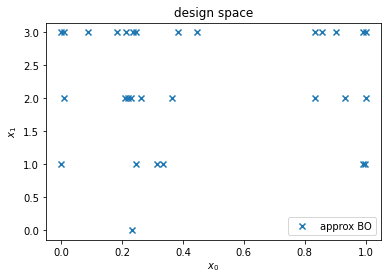

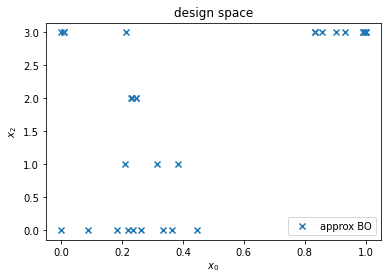

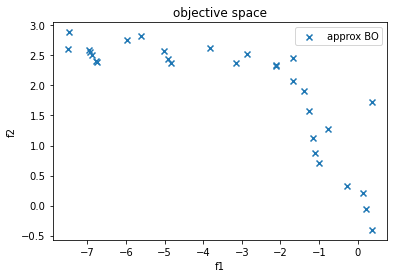

In [8]:
import matplotlib.pyplot as plt

x_opt = np.array(x_opt)
y_opt = np.array(y_opt)

plt.figure()
plt.scatter(x_opt[:,0], x_opt[:,1], marker='x',label = 'approx BO')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.title("design space")
plt.show()


plt.figure()
plt.scatter(x_opt[:,0], x_opt[:,2], marker='x',label = 'approx BO')
plt.xlabel('$x_0$')
plt.ylabel('$x_2$')
plt.legend()
plt.title("design space")
plt.show()

plt.figure()
plt.scatter( y_opt[:,0],  y_opt[:,1],marker='x', label = 'approx BO')
plt.xlabel('f1')
plt.ylabel('f2')
plt.legend()
plt.title("objective space")
plt.show()

In [9]:
optim.tell_doe(xdoe, ydoe)

In [10]:
x_opt, y_opt = optim.run(f_grouped, n_iter=5)

0 x suggested = [0.3766857122159265, 2.0, 0.0] with status: valid point
new y = [[ 0.37668571 -0.4324315   0.14189213 -0.42331429 -0.17668571]]
1 x suggested = [0.37698484985702474, 2.0, 0.0] with status: valid point
new y = [[ 0.37698485 -0.43152969  0.14211758 -0.42301515 -0.17698485]]
2 x suggested = [0.20000502330853606, 1.0, 2.0] with status: valid point
new y = [[-1.79999498e+00  2.00000000e+00  4.00020093e-02 -5.99994977e-01
  -5.02330854e-06]]
3 x suggested = [0.3478477788839741, 3.0, 3.0] with status: valid point
new y = [[-8.65215222  4.31563666  0.12099808 -0.45215222 -0.14784778]]
4 x suggested = [0.3499478492492242, 1.0, 1.0] with status: valid point
x_best=[[0.34122394932403893, 3.0, 3.0], [0.32114648296269793, 3.0, 3.0], [0.2232067926456353, 2.0, 0.0], [0.20491155004811806, 1.0, 2.0], [0.5361475330820975, 1.0, 2.0], [0.999999451854206, 3.0, 3.0], [0.034483020863101385, 2.0, 3.0], [0.4377301147406, 0.0, 1.0], [0.047278069496397665, 2.0, 2.0], [0.6989389987363539, 0.0, 1.0

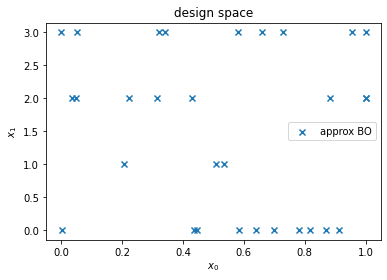

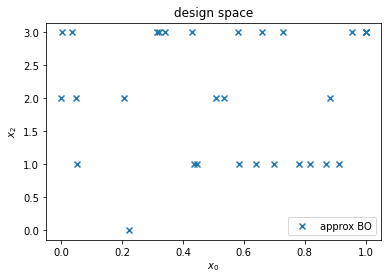

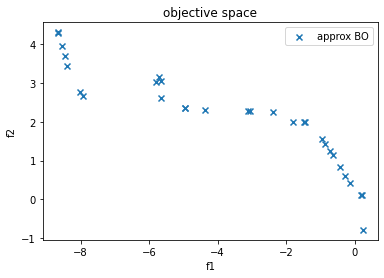

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(x_opt[:,0], x_opt[:,1], marker='x',label = 'approx BO')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.title("design space")
plt.show()


plt.figure()
plt.scatter(x_opt[:,0], x_opt[:,2], marker='x',label = 'approx BO')
plt.xlabel('$x_0$')
plt.ylabel('$x_2$')
plt.legend()
plt.title("design space")
plt.show()

plt.figure()
plt.scatter( y_opt[:,0],  y_opt[:,1],marker='x', label = 'approx BO')
plt.xlabel('f1')
plt.ylabel('f2')
plt.legend()
plt.title("objective space")
plt.show()

In [12]:
print(optim._id)

182


## Options

### Options for the optimization solver

In [14]:
# criterion="WB2S", "EHVI", "MPI", PI"
# If WB2S is chosen two other options: 'subcrit' has to be given
# subcrit= "EHVI", "MPI", "PI", by default: "EHVI" is set
# transfo=lambda x: np.sum(x): by default

# options={"n_clusters": 1, "n_start": 10, "criterion": "WB2S", "subcrit": "MPI" , "pop_size": 30, "n_gen": 30, "verbose": True, "debug": True}
options={"n_clusters": 1, "n_start": 10,  "verbose": True, "debug": True}

optim_options = MOOptimization(xtypes, n_obj=3, cstr_specs=cstr_specs, options=options)
print(options)
optim_options.tell_doe(xdoe, ydoe)
x_opt, y_opt = optim_options.run(f_grouped, n_iter=5)


{'n_clusters': 1, 'n_start': 10, 'verbose': True, 'debug': True}
0 x suggested = [0.6145321835484994, 3.0, 3.0] with status: valid point
new y = [[-8.38546782  4.58228738  0.3776498  -0.18546782 -0.41453218]]
1 x suggested = [0.7083544391022637, 1.0, 3.0] with status: valid point
new y = [[-2.29164556  2.58535132  0.50176601 -0.09164556 -0.50835444]]
2 x suggested = [0.20000077845510447, 1.0, 1.0] with status: valid point
new y = [[-7.99999222e-01  1.35999813e+00  4.00003114e-02 -5.99999222e-01
  -7.78455104e-07]]
3 x suggested = [0.5001914961557758, 1.0, 1.0] with status: valid point
new y = [[-0.4998085   1.00000015  0.25019153 -0.2998085  -0.3001915 ]]
4 x suggested = [0.49973571399963457, 1.0, 1.0] with status: valid point
x_best=[[0.39036869644758077, 3.0, 3.0], [0.420370093914336, 2.0, 2.0], [0.3717620482620602, 3.0, 3.0], [0.4201204183591866, 3.0, 3.0], [0.24545110566638606, 3.0, 3.0], [0.3891572279422599, 3.0, 3.0], [0.201602171633381, 3.0, 3.0]]
y_best=[[-8.641043584391284, 0.

In [15]:
print(optim_options._id)

183


### Optimization with mixed variables: float, integer and categorical variables

In [16]:
from smt.applications.mixed_integer import MixedIntegerSurrogateModel,  MixedIntegerSamplingMethod, INT, FLOAT, ENUM, cast_to_mixed_integer, unfold_with_enum_mask
from smt.sampling_methods import LHS
import numpy as np
from whatsopt.mooptimization import MOOptimization, FLOAT, INT, ENUM
import time

$$
\begin{array}{cl}
    \underset{x\in \mathbb{R}^3}{\min} (f_1(x),f_2(x),f_3(x)) & \\
    \mbox{with} & f_1=x_0-x_1x_2 \\
    & f_2= 4x_0^2 - 4x_0^{x_2} +1 + x_1\\
    & f_3= x_0^2\\
    \mbox{s.t.} & g_1(x)=x_0-0.8 \ge 0  \\
    &  g_2(x) = 0.2-x_0 \ge 0
\end{array}
$$

Here 
- $x_0\in [0,1] \subset \mathbb{R}$
- $x_1$ is a integer $\in \{0,1,2,3\}$  4 possibilities
- $x_2$ is a categorical variable $\in \{"blue","red","green"\}$ : 3 levels

In [17]:
def fun_mixed_color(x):#function with 3 objectives
    if x[2]=="blue":
        x2=0
    elif x[2]=="red":
        x2=1
    elif x[2]=="green":
        x2=2
    f1 = x[0] -np.float(x[1])*x2
    f2 = 4*x[0]**2 - 4*x[0]**x2 +1 + np.float(x[1])
    f3= x[0]**2
    return [f1,f2,f3]

def g1(x):#constraint to force x < 0.8
    return (x[0]-0.8, False)
def g2(x):#constraint to force x > 0.2
    return (0.2 - x[0], False)

# To group functions relative to objective &  constraint 
def f_grouped(x):
    #print('ds fgrouped',x)
    resfun = fun_mixed_color(x)
    resg1 = g1(x)[0]
    resg2 = g2(x)[0]
    #print(resfun, resg1,resg2)
    res = np.hstack((resfun, resg1, resg2))
    return res,False

# Specifications for constraints 
cstr_specs = 2*[{"type": '<', "bound": 0.0}]

# Definition of design variables 
xtypes_options = [FLOAT, INT,  (ENUM, 3)]
xlimits_options = np.array([[0.0, 1.0], [0,3], ["blue","red","green"]])
xtypes_whatsopt = [{"type": FLOAT, "limits": [0.0, 1.0]},
                   {"type": INT,  "limits": [0 , 3]},
                   {"type": ENUM,  "limits": ["blue","red","green"]}]

D:\rlafage\AppData\Local\Temp\ipykernel_3372\3733029899.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xlimits_options = np.array([[0.0, 1.0], [0,3], ["blue","red","green"]])


In [20]:
options={"n_clusters": 1, "n_start": 10, "criterion": "MPI", "pop_size": 30, "n_gen": 30, "verbose": True, "debug": True}
# options["mod_obj__type"]       ="MIXEDsmt"
# options["mod_obj__name"]       ="KPLS"
# options["mod_obj__n_comp"]     = 2 # PLS components to reduce the initial dimension
# options["mod_obj__eval_noise"] = False
# options["mod_obj__corr"]       = "squar_exp" # correlation kernel

In [21]:
from whatsopt.mooptimization import MOOptimization, FLOAT, INT, ENUM

optim = MOOptimization(xtypes_whatsopt, cstr_specs=cstr_specs, n_obj=3,  options=options)

In [22]:
sampling = MixedIntegerSamplingMethod(xtypes_options, xlimits_options, LHS, criterion="ese")

num = 20
xdoe = sampling(num)
print("Initial DOE")
print("xdoe={}".format(xdoe))

Initial DOE
xdoe=[[0.0467114  1.         0.        ]
 [0.52515334 3.         2.        ]
 [0.98860958 1.         1.        ]
 [0.67371691 0.         0.        ]
 [0.27937468 2.         2.        ]
 [0.17072136 1.         0.        ]
 [0.05891597 1.         2.        ]
 [0.86828996 2.         2.        ]
 [0.33907112 0.         1.        ]
 [0.77035571 3.         1.        ]
 [0.13580706 3.         1.        ]
 [0.58212573 1.         1.        ]
 [0.49684294 2.         1.        ]
 [0.92910482 2.         1.        ]
 [0.41488606 2.         0.        ]
 [0.3575309  0.         2.        ]
 [0.20844837 2.         2.        ]
 [0.72369114 1.         2.        ]
 [0.63697209 2.         0.        ]
 [0.80522156 0.         1.        ]]


In [23]:
# To have the DOE with the original values (float, integer and categorical)
xdoe_cat= [cast_to_mixed_integer(xtypes=xtypes_options,xlimits=xlimits_options,x=xdoe[i]) for i in range(len(xdoe))]
ydoe= np.array([f_grouped(xdoe_cat[i])[0] for i in range(len(xdoe))])
print('DOE with original  values - first elements - objectives \n', xdoe_cat[:5],'\n', ydoe[:5])
print('DOE to give to the WhatsOpt optimizer - first elements - obj & constraints \n', xdoe[:5],'\n', ydoe[:5])

DOE with original  values - first elements - objectives 
 [[0.046711395114645254, 1, 'blue'], [0.5251533376549689, 3, 'green'], [0.9886095828890722, 1, 'red'], [0.6737169119777868, 0, 'blue'], [0.2793746811682811, 2, 'green']] 
 [[ 4.67113951e-02 -1.99127218e+00  2.18195443e-03 -7.53288605e-01
   1.53288605e-01]
 [-5.47484666e+00  4.00000000e+00  2.75786028e-01 -2.74846662e-01
  -3.25153338e-01]
 [-1.13904171e-02  1.95495730e+00  9.77348907e-01  1.88609583e-01
  -7.88609583e-01]
 [ 6.73716912e-01 -1.18442209e+00  4.53894477e-01 -1.26283088e-01
  -4.73716912e-01]
 [-3.72062532e+00  3.00000000e+00  7.80502125e-02 -5.20625319e-01
  -7.93746812e-02]]
DOE to give to the WhatsOpt optimizer - first elements - obj & constraints 
 [[0.0467114  1.         0.        ]
 [0.52515334 3.         2.        ]
 [0.98860958 1.         1.        ]
 [0.67371691 0.         0.        ]
 [0.27937468 2.         2.        ]] 
 [[ 4.67113951e-02 -1.99127218e+00  2.18195443e-03 -7.53288605e-01
   1.53288605e-01]


In [24]:
optim.tell_doe(xdoe, ydoe)

In [25]:
# We loop using the iteration budget
n_iter = 10
with_best=False
for i in range(n_iter):
    with_best = with_best or (i == n_iter - 1)
    start_time = time.time()
    x_suggested, status, x_opt, y_opt = optim.ask(with_best)
    print("{} x suggested = {} with status: {}".format(i, x_suggested, MOOptimization.STATUSES[status]))
    print("--- %s seconds ---" % (time.time() - start_time))
    # compute objective functions & constraints  at the suggested point
    new_y = f_grouped(cast_to_mixed_integer(xtypes=xtypes_options,xlimits=xlimits_options,x=x_suggested))[0]
    print("new y = {}".format(new_y))
    
    optim.tell(x_suggested, new_y)
         
print("Found approx pareto y_opt = {} at x_opt = {}".format(y_opt, x_opt))

0 x suggested = [0.19999924098326644, 0.0, 0.0] with status: valid point
--- 14.987879991531372 seconds ---
new y = [ 1.99999241e-01 -2.84000121e+00  3.99996964e-02 -6.00000759e-01
  7.59016734e-07]
1 x suggested = [0.2000324974171205, 3.0, 2.0] with status: valid point
--- 12.913505792617798 seconds ---
new y = [-5.79996750e+00  4.00000000e+00  4.00130000e-02 -5.99967503e-01
 -3.24974171e-05]
2 x suggested = [0.20041431838473328, 3.0, 1.0] with status: valid point
--- 13.249317407608032 seconds ---
new y = [-2.79958568e+00  3.35900632e+00  4.01658990e-02 -5.99585682e-01
 -4.14318385e-04]
3 x suggested = [0.20055133145852055, 3.0, 1.0] with status: valid point
--- 12.844878673553467 seconds ---
new y = [-2.79944867e+00  3.35867802e+00  4.02208365e-02 -5.99448669e-01
 -5.51331459e-04]
4 x suggested = [0.20029626809602227, 1.0, 2.0] with status: valid point
--- 13.355016708374023 seconds ---
new y = [-1.79970373e+00  2.00000000e+00  4.01185950e-02 -5.99703732e-01
 -2.96268096e-04]
5 x su

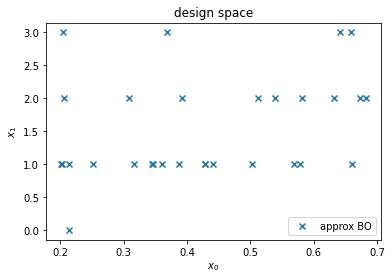

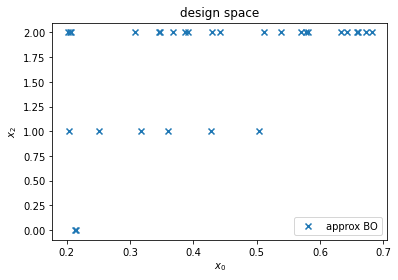

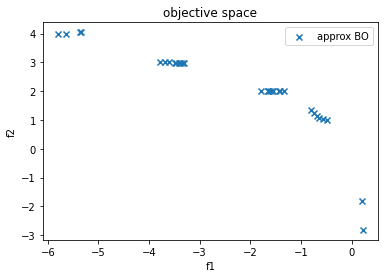

In [31]:
import matplotlib.pyplot as plt

x_opt = np.array(x_opt)
y_opt = np.array(y_opt)

plt.figure()
plt.scatter(x_opt[:,0], x_opt[:,1], marker='x',label = 'approx BO')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.title("design space")
plt.show()

plt.figure()
plt.scatter(x_opt[:,0], x_opt[:,2], marker='x',label = 'approx BO')
plt.xlabel('$x_0$')
plt.ylabel('$x_2$')
plt.legend()
plt.title("design space")
plt.show()

plt.figure()
plt.scatter( y_opt[:,0],  y_opt[:,1],marker='x', label = 'approx BO')
plt.xlabel('f1')
plt.ylabel('f2')
plt.legend()
plt.title("objective space")
plt.show()